In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

import jax
import jax.numpy as jnp
from scipy.optimize import NonlinearConstraint
jax.config.update("jax_enable_x64", True)
from scipy import optimize
import cvxpy as cp

 # №1

 # №2

$$ x_t = \alpha_t x_{t-1} + \omega_t $$
$$ \omega_t \sim N(0, 1) $$
$$ \alpha_t \in (-1, 1)$$
$$ \alpha_t = (\alpha_0, \alpha_0, \alpha_0, ..., \alpha_0, \alpha_1, \alpha_1, ..., \alpha_1, \alpha_2, ...) $$

$$ \sigma^2 =  \langle x_t^2 \rangle  = \langle (\alpha_t x_{t-1} + \omega_t)^2 \rangle =  \langle \alpha_t^2 x_{t-1}^2 + \omega_t^2 + 2 \alpha_t x_{t-1}\omega_t  \rangle  = $$

$$ = \langle \alpha^2 x_{t-1}^2 \rangle + \langle \omega_t^2 \rangle + 2 \langle \alpha x_{t-1}\omega_t  \rangle   = \alpha^2 \langle  x_{t-1}^2 \rangle +  1 = \langle  x_{t-1}^2 \rangle = \langle  x_{t}^2 \rangle $$

$$\langle  x_{t}^2 \rangle = \frac{1}{1 - \alpha^2}$$

$$ \langle x_t x_{t + r} \rangle  = \langle (\alpha x_{t-1} + \omega_t) (\alpha x_{t + r - 1} + \omega_{t+r}) \rangle =   $$

$$ = \langle \alpha^2 x_{t-1} x_{t+r-1} + \alpha \omega_t x_{t+r-1} +  \alpha x_{t-1} \omega_{t+r} + \omega_{t+r} \omega_t \rangle  = $$

$$ = \alpha^2 \langle  x_{t-1} x_{t+r-1} \rangle  = \langle  x_{t} x_{t+r} \rangle  $$

$$\langle  x_{t} x_{t+r} \rangle = 0 $$

Text(0.5, 1.0, 'alpha')

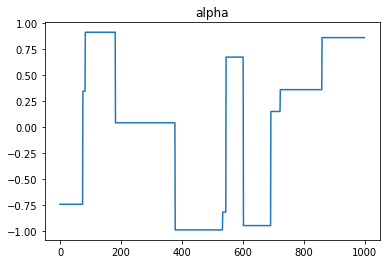

In [31]:
def gen_alpha(T, n_switch):
    sw_points = set()
    while len(sw_points) < n_switch:
        sw_points.add(int(np.random.uniform(0, T - 1)))
    alpha = [ np.random.uniform(-1, 1) ]
    for i in range(T - 1):
        alpha.append(alpha[-1])
        if i in sw_points:
            alpha[-1] = np.random.uniform(-1, 1)
    return alpha

T = 1000
n_switch = 10
alpha = gen_alpha(T, n_switch)
plt.plot(alpha)
plt.title("alpha")

Text(0.5, 1.0, 'x')

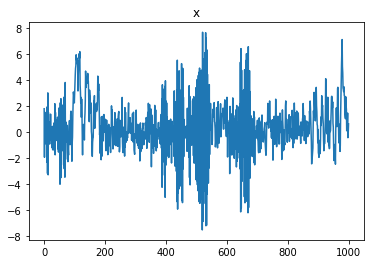

In [32]:
def gen_x(a, T):
    x = [ np.random.normal() ]
    for i in range(T - 1):
        x.append(a[i + 1] * x[-1] + np.random.normal(0, 1))
    return x

x = gen_x(alpha, T)
plt.plot(x)
plt.title("x")

$$ \sum\limits_{t=1}^T \left[ \left( x_t - \alpha_t x_{t-1}\right)^2 + \gamma |\alpha_t - \alpha_{t-1}|\right] \rightarrow \min $$


23

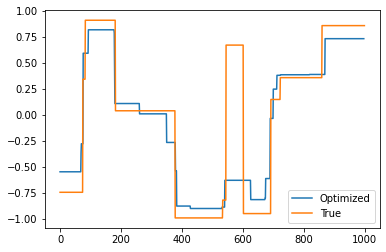

In [33]:
def minimize(x, gamma, T1, true_alpha = None, autoplot = False):
    a = cp.Variable(T1 - 2)
    goal = cp.norm(cp.multiply(x[1:-1], a) - x[2:])**2
    reg = cp.norm(a[1:]-a[:-1], 1)
    problem = cp.Problem(cp.Minimize(goal + gamma * reg))
    problem.solve()
    if autoplot:
        plt.plot(a.value, label="Optimized")
        if true_alpha is not None:
            plt.plot(true_alpha, label="True")
        plt.legend()
    return a.value

def analyze(a):
    ret = 0
    for i in range(1, len(a)):
        if not np.isclose(a[i - 1], a[i]):
            ret += 1
    return ret

analyze(minimize(x, 120, T, alpha, True))

In [34]:
gammas = {}
failed = 0
for g in range(10, 1200, 30):
    stat = []
    for i in range(40):
        try:
            print(f"{g=:5}, {i=:5}, {failed=:5}", end='\r')
            A = gen_alpha(T)
            X = gen_x(A, T)
            C = analyze(minimize(X, g, T))
            stat.append(np.abs(C - 10))
        except:
            failed += 1
    gammas[g] = np.mean(stat)
    

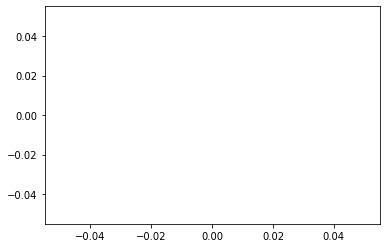

In [35]:
plt.plot(gammas.keys(), gammas.values())

In [36]:
x1 = np.load('data/x.npy')
x1

array([ 0.42071315, -2.60450136,  2.39133343, ...,  0.17668246,
        2.72977002,  1.33371582])

In [37]:
analyze(minimize(x1, 116, x1.shape[0]))

164

In [8]:
gs = {}
f = 0
for g in range(10, 1000, 1):
    print(f"{g=}, {f=}", end='\r')
    try:
        gs[g] = analyze(minimize(x1, g, x1.shape[0]))
    except:
        f += 1

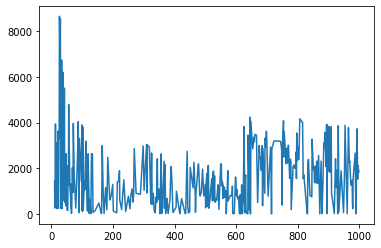

In [9]:
plt.plot(gs.keys(), gs.values())

In [10]:
K = np.array(list(gs.keys()))
V = np.array(list(gs.values()))

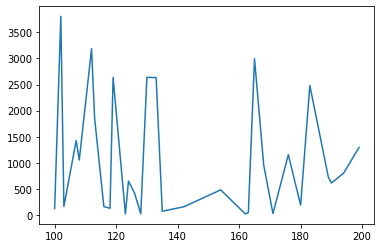

In [11]:
I = np.logical_and(K >= 100, K <= 200)
plt.plot(K[I], V[I])